# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
# trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))


In [ ]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [16]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [17]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_77248\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [18]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [19]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [20]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2314.45,2214.75,1.00,-176.97,77.27,-99.70,-4.31
BTCUSDT,601.02,1041.28,0.47,3.54,440.26,443.80,19.18
SOLUSDT,281.20,344.14,0.16,0.00,62.94,62.94,2.72
ETHUSDT,250.75,310.03,0.14,0.00,59.29,59.29,2.56
JASMYUSDT,387.46,211.21,0.10,0.00,-176.25,-176.25,-7.62
TRXUSDT,76.87,171.20,0.08,-10.72,94.33,83.61,3.61
OMUSDT,526.32,119.25,0.05,0.00,-407.07,-407.07,-17.59
BNBUSDT,13.87,17.64,0.01,-10.61,3.77,-6.84,-0.30
BBUSDT,0.01,0.00,0.00,-84.82,-0.00,-84.82,-3.66
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

125

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 074764dce855e27d7c3ecc942a25b808ccc103a4)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 8b459a5300b213e186426cdae956e361421b5092)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-08-12   -166.937050
2025-08-13   -101.896776
2025-08-14   -218.841594
2025-08-15   -252.630296
2025-08-16     65.642239
Name: Total, Length: 328, dtype: float64

<Axes: >

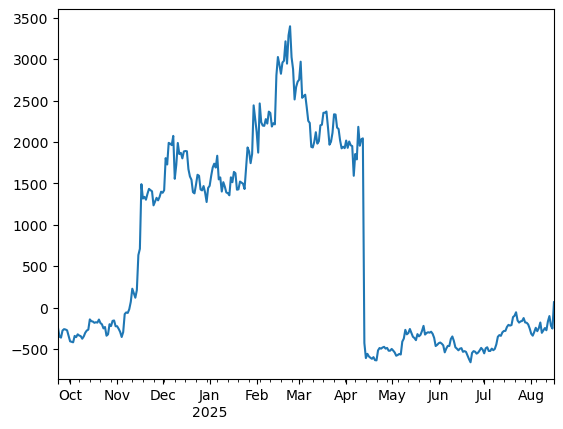

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-30:]

2025-07-18     -8.924780
2025-07-19      6.695876
2025-07-20     95.941730
2025-07-21     16.674338
2025-07-22     41.891706
2025-07-23    -99.585907
2025-07-24    -25.169421
2025-07-25     14.611312
2025-07-26      4.924152
2025-07-27     35.123826
2025-07-28    -52.773000
2025-07-29     -3.735193
2025-07-30    -20.315121
2025-07-31    -49.767968
2025-08-01    -62.484839
2025-08-02    -23.659997
2025-08-03     44.829219
2025-08-04     50.440091
2025-08-05    -41.020054
2025-08-06     36.413389
2025-08-07     68.439267
2025-08-08   -124.710668
2025-08-09     28.638649
2025-08-10     28.580156
2025-08-11    -26.126058
2025-08-12    106.411481
2025-08-13     65.040275
2025-08-14   -116.944819
2025-08-15    -33.788702
2025-08-16    318.272535
Name: Total, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.35019028391105, -950.5160328166933)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

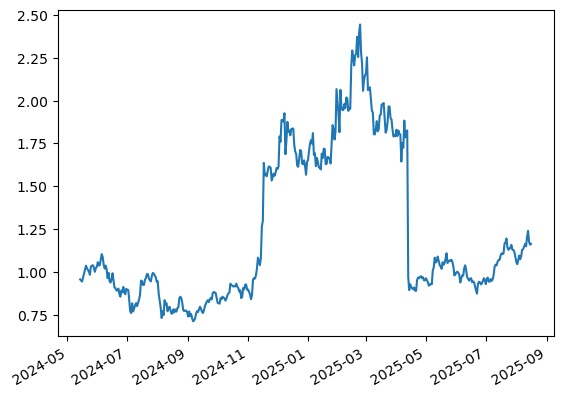

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

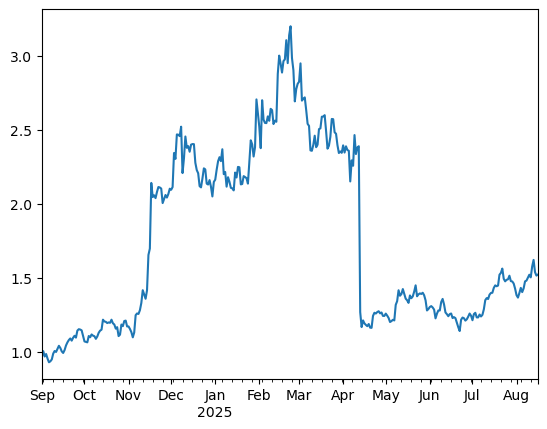

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [60]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [61]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.4011
TRXUSDT,0.1964
ADAUSDT,0.0975
WBTCUSDT,0.0934
XRPUSDT,0.0890
BTCUSDT,0.0731
OMUSDT,0.0452
SUIUSDT,0.0044
AVAXUSDT,0.0000
LTCUSDT,0.0000


In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.384418
WBTCUSDT,0.260360
TRXUSDT,0.193838
XRPUSDT,0.117899
OMUSDT,0.038171
SUIUSDT,0.005315


In [66]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

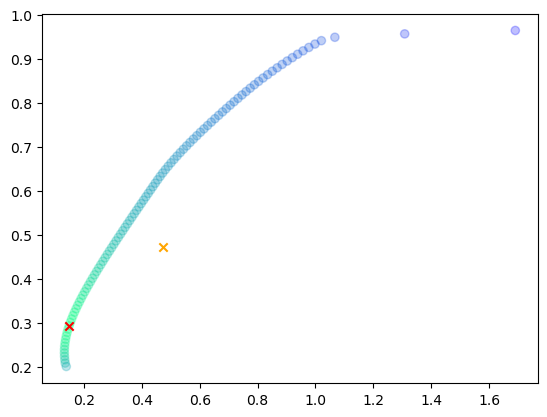

In [67]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [68]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1041.2790,0.4702,0.0000,0.4702
SOLUSDT,344.1411,0.1554,0.0000,0.1554
ETHUSDT,310.0333,0.1400,0.0000,0.1400
JASMYUSDT,211.2108,0.0954,0.0000,0.0954
TRXUSDT,171.1965,0.0773,0.0268,0.0505
OMUSDT,119.2462,0.0538,0.0050,0.0488
BNBUSDT,17.6436,0.0080,0.0523,-0.0443
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0004,-0.0004
PAXGUSDT,0.0000,0.0000,0.7440,-0.7440


### Current results

In [71]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [72]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.643528
TRXUSDT,0.356472


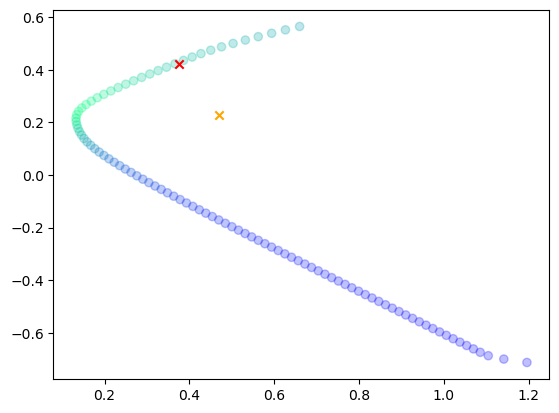

In [73]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [74]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1041.2790,0.4702,0.6435,-0.1734
SOLUSDT,344.1411,0.1554,0.0000,0.1554
ETHUSDT,310.0333,0.1400,0.0000,0.1400
JASMYUSDT,211.2108,0.0954,0.0000,0.0954
TRXUSDT,171.1965,0.0773,0.3565,-0.2792
OMUSDT,119.2462,0.0538,0.0000,0.0538
BNBUSDT,17.6436,0.0080,0.0000,0.0080
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

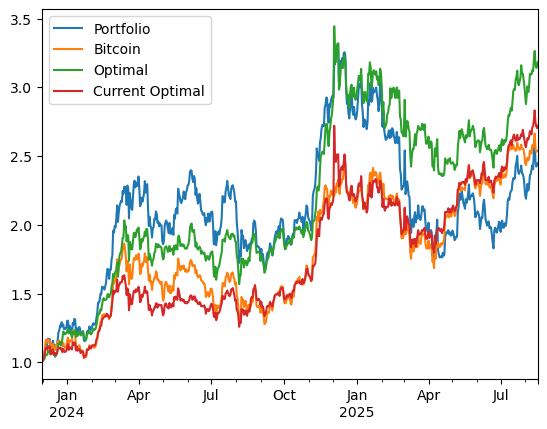

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

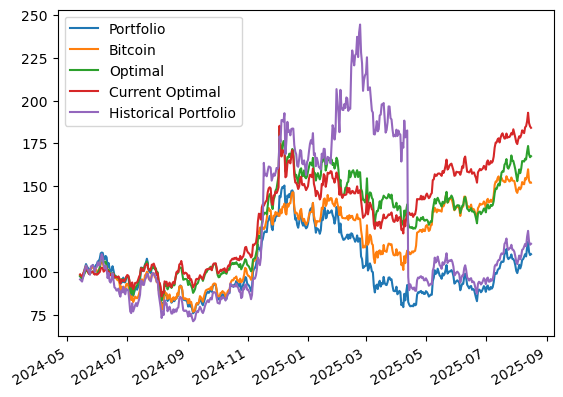

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-08-07,107.030070,152.431029,164.687529,182.611435,112.908559
2025-08-08,107.409476,151.392970,164.617232,181.695630,113.269675
2025-08-09,108.899149,151.116999,164.389396,180.982039,114.803097
2025-08-10,110.327506,154.747423,166.032074,184.373941,116.313837
2025-08-11,109.000182,153.956700,165.598388,185.056606,114.941611
2025-08-12,114.295493,155.823749,170.068508,187.900806,120.542351
2025-08-13,117.543614,159.885155,173.468455,192.871243,123.941736
2025-08-14,111.576751,153.251473,168.580271,186.842536,117.649222
2025-08-15,109.840231,152.011808,166.907540,184.950706,115.859840
2025-08-16,110.328527,152.061818,167.526610,184.086185,116.362675


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.376979
 dtype: float64,
 0.3772777952154154)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.470647
 dtype: float64,
 0.4706465276823938)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.471992
Bitcoin            0.407442
Optimal            0.377278
Current Optimal    0.370994
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5336271629838248

In [87]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

1.251970001670494

<Axes: >

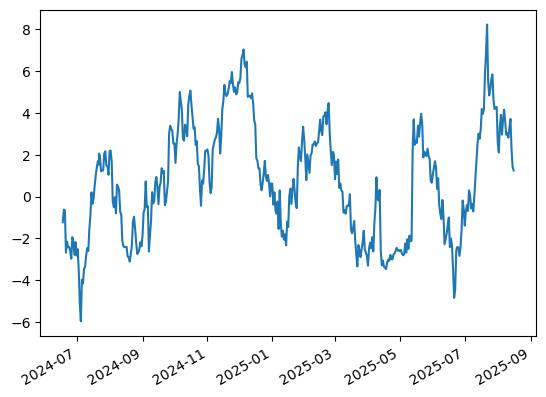

In [88]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [89]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.4828816568496811

## Risk Contribution

In [91]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,75.1699,0.3806,0.2006,0.1800
WBTCUSDT,40.2233,0.2215,0.0776,0.1439
TRXUSDT,26.3067,0.1780,0.0906,0.0874
XRPUSDT,21.7875,0.1440,0.0471,0.0970
SUIUSDT,0.6460,0.0074,0.0002,0.0072
OMUSDT,-38.1369,0.0685,0.0292,0.0393
Portfolio,125.9965,1.0000,0.4452,0.5548


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,40.751948,0.522399,0.438912,0.083487
TRXUSDT,35.580373,0.477601,0.394114,0.083487
Portfolio,76.332321,1.000000,0.833025,0.166975


In [93]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,29.468458,0.344226,0.145370,0.198856
TRXUSDT,7.905943,0.040995,0.012325,0.028670
ETHUSDT,1.370199,0.150570,0.030801,0.119769
BNBUSDT,0.239866,0.006499,0.000073,0.006427
SOLUSDT,-2.599072,0.204838,0.055027,0.149810
JASMYUSDT,-6.491723,0.175172,0.047760,0.127412
OMUSDT,-7.969543,0.077702,0.033613,0.044089
Portfolio,21.924127,1.000000,0.324968,0.675032


# Value At Risk

## Historical

### Optimal Weights

In [97]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.0649618968951826, -0.08156238014159932)

### Current Weights

In [99]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08116497121418631, -0.09799707322817151)

In [100]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [101]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.030604
SOLUSDT     -0.012631
ETHUSDT     -0.012029
JASMYUSDT   -0.016992
TRXUSDT     -0.003895
OMUSDT      -0.002814
BNBUSDT     -0.000664
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.079629
Name: 2025-03-09 00:00:00, dtype: float64

In [102]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025193
SOLUSDT     -0.019137
ETHUSDT     -0.013812
JASMYUSDT   -0.013394
TRXUSDT     -0.004170
OMUSDT      -0.018608
BNBUSDT     -0.000623
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.094936
dtype: float64

## Parametric

### Optimal Weights

In [105]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.0552886051151597, -0.06847855417628353)

### Current Weights

In [107]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.06897143258323868, -0.08542563106682845)

## Multivariate

### Optimal Weights

In [110]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0525455076935977, -0.06049387730086023)

### Current Weights

In [112]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06930168079340437, -0.0788061400660383)

In [113]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.022786
SOLUSDT     -0.013576
ETHUSDT     -0.010307
JASMYUSDT   -0.012799
TRXUSDT     -0.003058
OMUSDT      -0.005107
BNBUSDT     -0.000434
Portfolio   -0.068069
dtype: float64

In [114]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.021484
SOLUSDT     -0.014507
ETHUSDT     -0.010028
JASMYUSDT   -0.013426
TRXUSDT     -0.003116
OMUSDT      -0.005992
BNBUSDT     -0.000434
Portfolio   -0.068987
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [118]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.052504640491329566, -0.060376631443560515)

### Current Weights

In [120]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06622822537666369, -0.07738246100139885)

In [121]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [124]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05421790554058984, -0.0615384092104262)

### Current Weights

In [126]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06915331895245277, -0.08023348172127619)

In [127]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [130]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08364890261132085, -0.09923602452842284)

### Current Weights

In [132]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09040639012496253, -0.11024956115233822)

In [133]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [136]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [137]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.054916359997172544, -0.062263392434916895)

### Current Weights

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06845192603131257, -0.07862618067960608)

In [140]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [141]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.030597,-0.023056,-0.016565,-0.022786,-0.023991
SOLUSDT,-0.008986,-0.013616,-0.009968,-0.013576,-0.014686
ETHUSDT,-0.003797,-0.010216,-0.007308,-0.010307,-0.010741
JASMYUSDT,-0.005901,-0.011772,-0.008984,-0.012799,-0.012222
TRXUSDT,-0.002501,-0.002526,-0.002349,-0.003058,-0.002235
OMUSDT,-0.006044,-0.006370,-0.004177,-0.005107,-0.005494
BNBUSDT,0.000059,-0.000429,-0.000344,-0.000434,-0.000455
Portfolio,-0.057766,-0.067985,-0.049695,-0.068069,-0.069824


In [142]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.027473,-0.023160,-0.017407,-0.021484,-0.024554
SOLUSDT,-0.010178,-0.013975,-0.010396,-0.014507,-0.015071
ETHUSDT,-0.005700,-0.009847,-0.007712,-0.010028,-0.010627
JASMYUSDT,-0.005544,-0.013127,-0.008637,-0.013426,-0.012755
TRXUSDT,-0.003412,-0.002668,-0.002249,-0.003116,-0.002138
OMUSDT,-0.006214,-0.005620,-0.003374,-0.005992,-0.005072
BNBUSDT,0.000031,-0.000405,-0.000348,-0.000434,-0.000459
Portfolio,-0.058489,-0.068801,-0.050123,-0.068987,-0.070677


## VaR Violation

In [144]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.031128,-0.040325,-0.032607,0.007165
2023-12-31,-0.031128,-0.040453,-0.035045,-0.001360
2024-01-01,-0.031128,-0.040661,-0.034875,0.016337
2024-01-02,-0.031128,-0.040597,-0.033232,0.005933
2024-01-03,-0.031128,-0.041559,-0.036269,-0.021458
...,...,...,...,...
2025-08-13,-0.027426,-0.040267,-0.035994,0.019992
2025-08-14,-0.029033,-0.042345,-0.037730,-0.028179
2025-08-15,-0.029033,-0.041931,-0.039070,-0.009922
2025-08-16,-0.029033,-0.040574,-0.038446,0.003709


In [145]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.024234,-0.078127,-0.069882,-0.016033
2024-05-29,-0.017747,-0.076051,-0.067569,-0.009014
2024-05-30,-0.017747,-0.064157,-0.059759,0.023635
2024-05-31,-0.017747,-0.063069,-0.054843,0.005881
2024-06-01,-0.017747,-0.061390,-0.056611,0.015606
...,...,...,...,...
2025-08-13,-0.030717,-0.055040,-0.049805,0.028419
2025-08-14,-0.048119,-0.064376,-0.060934,-0.050763
2025-08-15,-0.048119,-0.063236,-0.058423,-0.015563
2025-08-16,-0.046557,-0.058865,-0.052603,0.004446


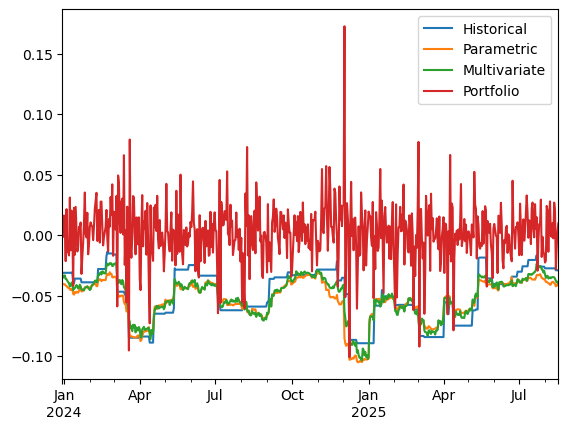

In [146]:
var_data.plot()
plt.show()

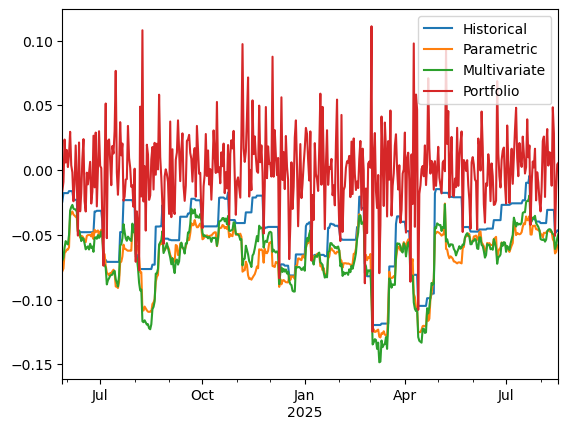

In [147]:
current_var_data.plot()
plt.show()


In [148]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031826,0.018425,0.01675
Kupiec Stat,4.739915,16.357307,18.51478
P-value,0.029471,0.000052,0.000017


In [149]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064877,0.017897,0.01566
Kupiec Stat,1.911918,12.741395,14.995469
P-value,0.16675,0.000358,0.000108


# Principal Component Analysis

## Historical PCA

In [152]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.58344122, 0.23080819, 0.07737144, 0.05985477, 0.04852438])

In [153]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.062155
AVAXUSDT     0.062637
BCHUSDT      0.047618
BNBUSDT      0.027613
BTCUSDT      0.031850
DOGEUSDT     0.065176
ETHUSDT      0.045581
HBARUSDT     0.063110
JASMYUSDT    0.072908
LINKUSDT     0.058311
LTCUSDT      0.043996
OMUSDT       0.072085
PAXGUSDT     0.000493
PEPEUSDT     0.083171
SOLUSDT      0.055026
SUIUSDT      0.060913
TRXUSDT      0.018343
USDCUSDT    -0.000159
WBTCUSDT     0.031626
XLMUSDT      0.049552
XRPUSDT      0.047997
Name: PC1, dtype: float64

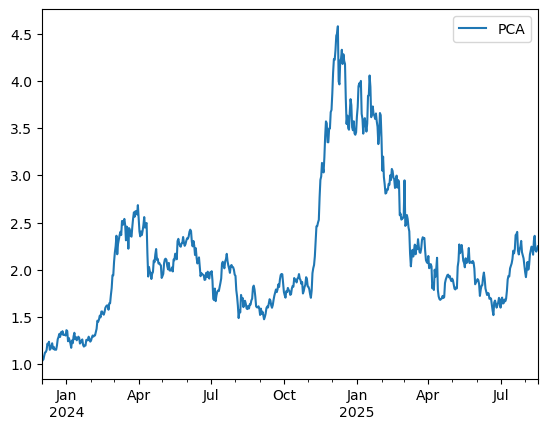

In [154]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

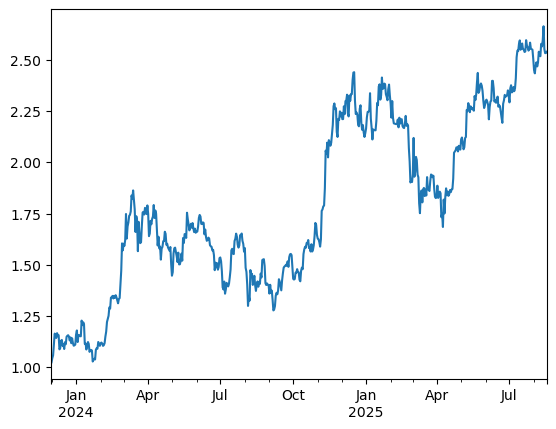

In [155]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [156]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.531217
WBTCUSDT     0.563132
BTCUSDT      0.563656
AVAXUSDT     0.671373
SOLUSDT      0.677432
LINKUSDT     0.692810
DOGEUSDT     0.697816
LTCUSDT      0.719689
BNBUSDT      0.720261
ADAUSDT      0.734539
XRPUSDT      0.769114
BCHUSDT      0.839160
XLMUSDT      0.905011
USDCUSDT     0.958508
PAXGUSDT     0.971792
SUIUSDT      1.073750
TRXUSDT      1.087798
HBARUSDT     1.100437
JASMYUSDT    1.215612
dtype: float64

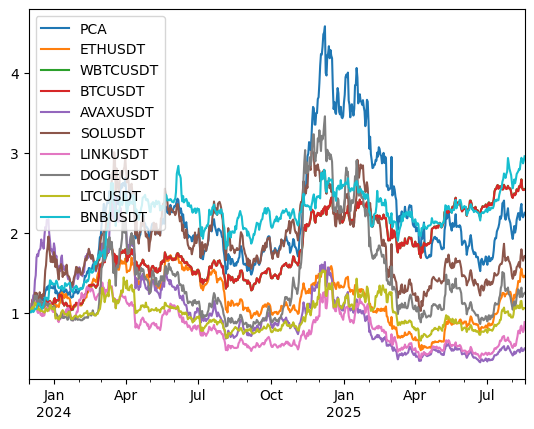

In [157]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

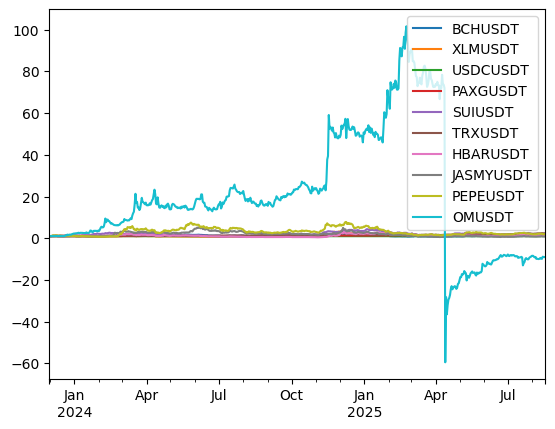

In [158]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [160]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52447882, 0.30206999, 0.06897643, 0.06304122, 0.04143354])

In [161]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049568
SOLUSDT      0.092952
ETHUSDT      0.080903
JASMYUSDT    0.141708
TRXUSDT      0.034380
OMUSDT       0.240579
BNBUSDT      0.051077
BBUSDT       0.170227
PEPEUSDT     0.137571
PAXGUSDT     0.001035
Name: PC1, dtype: float64

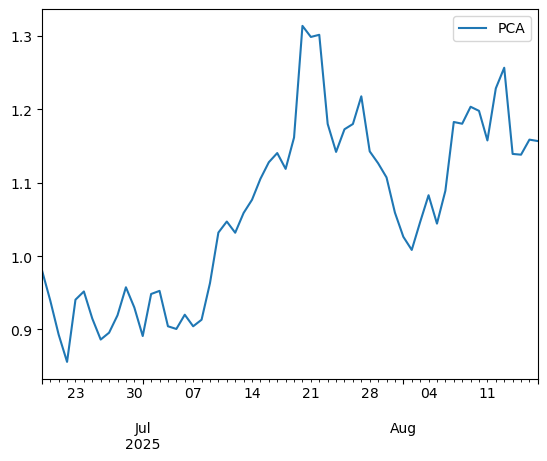

In [162]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

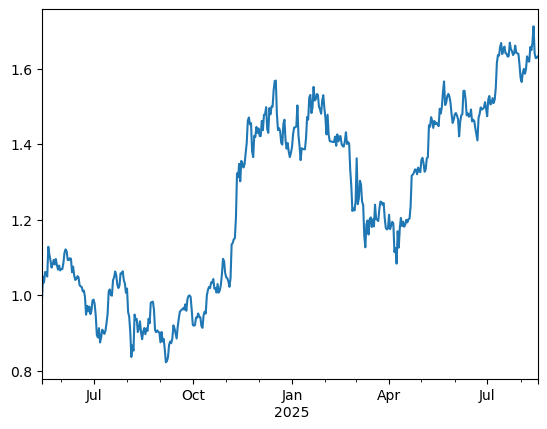

In [163]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [164]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.735485
SOLUSDT      0.773857
BTCUSDT      0.795767
BNBUSDT      0.798657
JASMYUSDT    0.976178
PEPEUSDT     1.011159
PAXGUSDT     1.058927
BBUSDT       1.080687
TRXUSDT      1.176915
dtype: float64

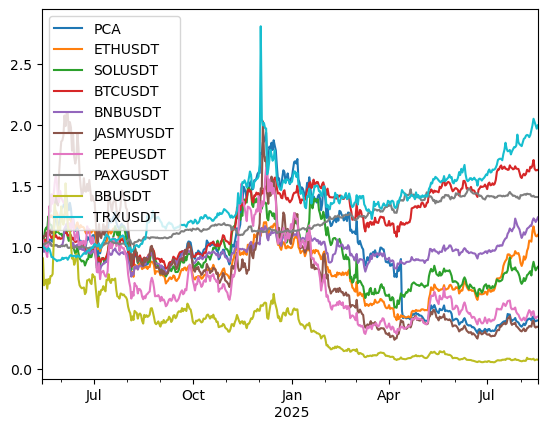

In [165]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [167]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.919498
BBUSDT       1.643037
JASMYUSDT    1.469188
SOLUSDT      1.286746
ETHUSDT      1.094358
BTCUSDT      1.000000
OMUSDT       0.993418
BNBUSDT      0.663405
TRXUSDT      0.331915
PAXGUSDT     0.028544
Name: BTCUSDT, dtype: float64

In [168]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       3.970006
JASMYUSDT    2.342831
SOLUSDT      1.964367
PEPEUSDT     1.930672
ETHUSDT      1.481750
OMUSDT       1.088198
BTCUSDT      1.000000
BNBUSDT      0.959277
TRXUSDT      0.463370
PAXGUSDT     0.099612
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [171]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.300055
BNBUSDT,0.199421
TRXUSDT,0.188392
SOLUSDT,0.121038
ETHUSDT,0.096392
OMUSDT,0.084683
JASMYUSDT,0.082626
BBUSDT,0.061759
PAXGUSDT,-0.009738
BTCUSDT,-0.095543


### Regression to PCA

In [173]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4628068781130266

In [174]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.316162
BNBUSDT      1.131457
PCA          1.000000
ETHUSDT      0.872795
SOLUSDT      0.728468
JASMYUSDT    0.466985
PEPEUSDT     0.459078
BBUSDT       0.370282
TRXUSDT      0.286830
PAXGUSDT     0.234260
OMUSDT       0.161200
dtype: float64

In [175]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.672940
BNBUSDT      1.340640
PAXGUSDT     1.207981
PCA          1.000000
ETHUSDT      0.937517
SOLUSDT      0.769907
PEPEUSDT     0.738358
JASMYUSDT    0.630200
TRXUSDT      0.496258
BBUSDT       0.267385
OMUSDT       0.262738
dtype: float64

### Correlation Matrix

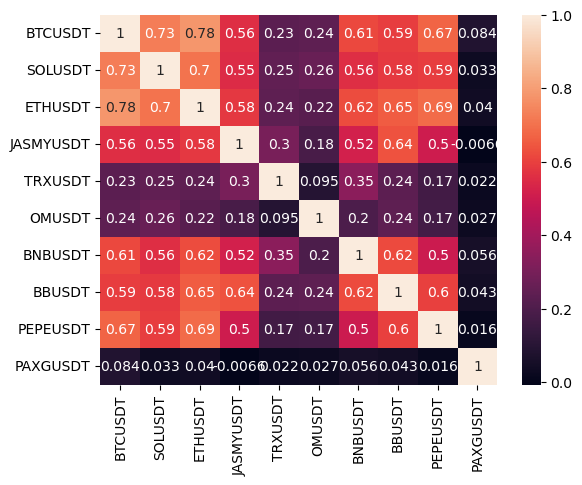

In [177]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

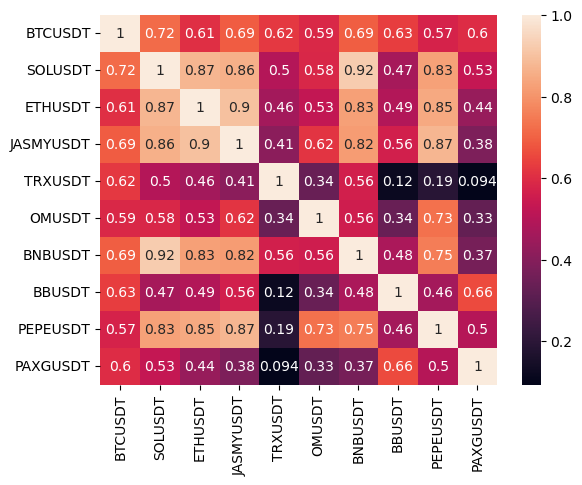

In [178]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [179]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [180]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

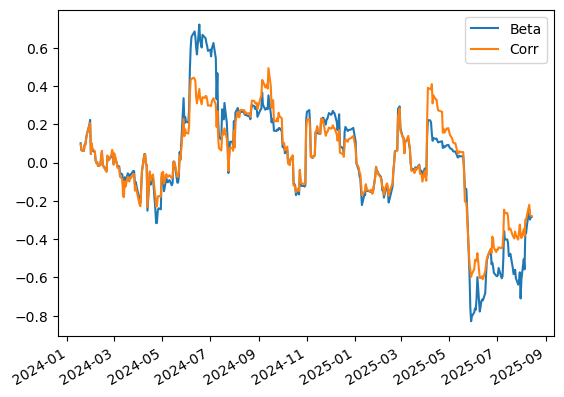

In [181]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [183]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BNBUSDT,BBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.000000,0.003604,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526887,0.176734,0.000000,0.000000,0.130357,0.000000


In [184]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [185]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,JASMYUSDT,LINKUSDT,...,OMUSDT,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-09,0.106751,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.893249,0.000000,0.0,0.0,0.00000,0.0
2025-02-08,0.106751,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.893249,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-03-10,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-04-09,0.106751,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.843941,0.049308,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-05-09,0.106751,0.0,0.004312,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.582500,0.000000,0.040271,0.087033,0.085708,0.0,0.0,0.00000,0.0
2025-06-08,0.106751,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.893249,0.0,0.0,0.00000,0.0
2025-07-08,0.106751,0.0,0.893249,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-08-07,0.106751,0.0,0.000000,0.000000,0.0,0.0,0.260395,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.474086,0.0,0.0,0.01229,0.0
2025-08-17,0.626293,0.0,0.000000,0.134741,0.0,0.0,0.000000,0.0,0.0,0.238966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0


In [186]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT    0.474086
ETHUSDT    0.260395
LTCUSDT    0.146479
ADAUSDT    0.106751
XLMUSDT    0.012290
BTCUSDT    0.000000
Name: 2025-08-07 00:00:00, dtype: float64

<Axes: >

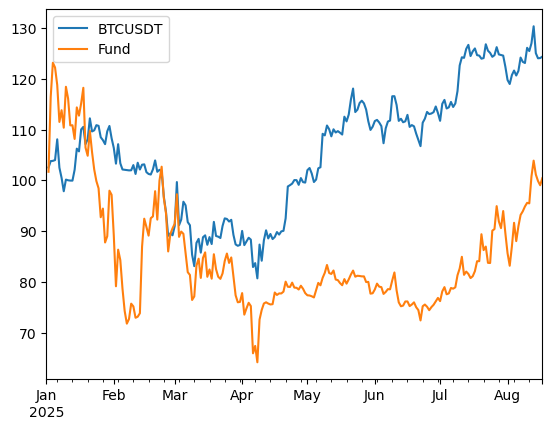

In [187]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [188]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

SUIUSDT      378.868570
BCHUSDT       76.102775
OMUSDT        31.778962
PAXGUSDT      31.659019
TRXUSDT       25.787323
ETHUSDT       23.254310
PEPEUSDT      18.492283
XRPUSDT        0.000000
AVAXUSDT       0.000000
USDCUSDT       0.000000
LINKUSDT       0.000000
JASMYUSDT      0.000000
HBARUSDT       0.000000
DOGEUSDT       0.000000
BTCUSDT        0.000000
BNBUSDT        0.000000
WBTCUSDT       0.000000
XLMUSDT       -0.222514
SOLUSDT       -2.585378
ADAUSDT       -4.954561
LTCUSDT       -8.135766
Name: 2025-08-17 00:00:00, dtype: float64

In [189]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
